# Solve the NN driven model in a scene

## Import libraries

In [1]:
# Python libraries
import os
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import tensorflow as tf
import matplotlib.pyplot as plt

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Using ipynb import functions defined in other nb
from ipynb.fs.defs.myfun_load_dataset import *
from ipynb.fs.defs.myfun_models import *
from ipynb.fs.defs.myfun_plot import *

2023-08-25 15:13:47.933156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
sklearn: 1.3.0


## Data Acquisition

In [2]:
# Load the dataset
par_dir = os.path.dirname(os.getcwd()) # parent dir
dir_name = par_dir + "/NN-interaction"
merged_df, dflist = load_dataset(dir_name, 'post') # we have 10 pandas dataframe, one for each couple(camera,sequence)

In [3]:
# For sake of simplicity conseder only a scene
df = dflist[0] # sequence
scn = df.T[0]  # scene

In [4]:
scn

Tarr           [9.440000000000001, 9.64, 9.840000000000002, 1...
Xarr           [[29.373325674060805, 34.22142942994519, 38.50...
Cons Dis       [[28.985128254938463, 28.827356057195246, 29.0...
N. vehicles                                                    3
cam                                                            1
day                                                            1
seq                                                            1
N. file                                                        1
Name: 0, dtype: object

In [5]:
# Useful params
N = scn['N. vehicles']
tstamps = scn['Tarr']

In [6]:
scn['Xarr']

array([[29.37332567, 34.22142943, 38.50653306, 43.68772327, 39.53432096,
        42.9844338 ],
       [58.35845393, 63.04878549, 67.56118147, 73.20173178, 49.09293513,
        56.45433487],
       [60.14504406, 65.53744755, 70.75192501, 78.36474838, 79.44444985,
        86.59041956]])

## Just to know the input of the NN

In [7]:
# Just to see what will be the X and y for our NN
X_arr, y_arr = create_data_ann_scene(scn)

In [8]:
print(f"We solve the NN driven ODE sys in each time interval of len=0.2s inside [{tstamps[0]},{tstamps[-1]}].\n")

We solve the NN driven ODE sys in each time interval of len=0.2s inside [9.440000000000001,10.440000000000001].



In [9]:
print(f"In the first time interval [{tstamps[0]},{tstamps[1]}] we evaluate our NN using as:\n\
\t * X: {X_arr[:,1]} (consecutive distances btw the {N} vehicles)\n\
\t * y: {y_arr[:,1]} (approximated velocities)")

In the first time interval [9.440000000000001,9.64] we evaluate our NN using as:
	 * X: [28.82735606  2.48866206] (consecutive distances btw the 3 vehicles)
	 * y: [21.42551813 22.56197993] (approximated velocities)


## Create the model NN

In [10]:
DOE =[[1,2,1]] #Design of experiment

In [11]:
model = create_model(DOE[0])
# model.summary()

/home/andrea/anaconda3/envs/tesi/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Evaluate the NN in each time interval

In [12]:
# parameters to set
epochs = 200           # An epoch is an iteration over the entire x and y data provided
batch_size = 100       # Number of samples per gradient update.
v0 = 30
deltat = 0.05

In [13]:
t_ann_list, x_ann_list, _ = odesolver_ann_scene(model, scn, batch_size, epochs, v0, deltat, verbose=0)

We have 5 time intervals inside [9.44,10.44]

----------------------------------------------------------------------------------------------------
Time interval n.0: [9.44, 9.64]

        * y_true: [24.24051878 23.45165779]
        * y_pred: [3.449268102645874, 0.6312088966369629]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Time interval n.1: [9.64, 9.84]

        * y_true: [21.42551813 22.56197993]
        * y_pred: [8.954209327697754, 1.5317424535751343]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Time interval n.2: [9.84, 10.04]

        * y_true: [25.90595108 28.20275155]
        * y_pred: [16.591957092285156, 2.928370475769043]

----------------------------------------

### Plot

In [14]:
# Params for the plot
trajs = [scn['Xarr'], np.array(x_ann_list)]
labels_plot = ["true","nn sim"]
title = f"Trajs simulated by NN driven LWR model"

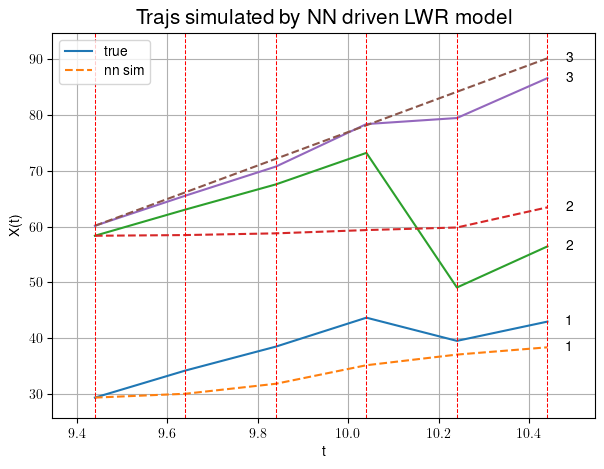

In [15]:
# fig 
width, height = 7, 5
fig, ax = plt.subplots(figsize=(width,height))

for veh in range(0,N):
    ax.plot(tstamps, scn['Xarr'][veh])
    ax.plot(t_ann_list, x_ann_list[veh], '--')

for ts in tstamps:
    ax.axvline(x = ts, color = 'red', linestyle = '--', linewidth=0.75)
    
# Annotate the name of each variable at the last value
plot_annotation(ax, scn, trajs, scale=1.004)

ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(title, fontsize=15)
# Limits for the plot
plot_limits(ax, scn, trajs, xbal=0.01, ybal=0.05)
plt.legend(labels_plot)
plt.grid()
plt.show()

## Match the computed solution to the same timestamps of the scene

In [16]:
# To recover the same timestep in the data
factor = int(0.2/deltat)

if len(set(tstamps - np.array(t_ann_list)[::factor])) == 1:
    print(f"timestamps coincide!")
    print("* tstamps: \t\t\t", tstamps,\
          "\n* np.array(t_ann_list): \t",np.array(t_ann_list)[::factor])
else:
    print(f"There is a mismatch in the timestamps: tstamps != tspan[::factor]")

timestamps coincide!
* tstamps: 			 [ 9.44  9.64  9.84 10.04 10.24 10.44] 
* np.array(t_ann_list): 	 [ 9.44  9.64  9.84 10.04 10.24 10.44]


In [17]:
## To match solution and timestamps
t_ann = np.array(t_ann_list)[::factor]
x_ann = np.array([traj[::factor] for traj in x_ann_list])